# Replication notebook - UrbanSim maps

Sam Maurer, December 2017, Python 3.6

In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Map of home prices vs. accessibility

In [4]:
# Load observed home prices from Bay Area UrbanSim
path = '/Users/maurer/Dropbox/Data/MTC/UrbanSim/2015_09_01_bayarea_v3.h5'
store = pd.HDFStore(path)
print(store.keys())

['/buildings', '/households', '/jobs', '/jobs_urbansim_allocated', '/parcels', '/zones']


In [9]:
parcels = pd.read_hdf(path, 'parcels')
print(len(parcels))
print(parcels.columns.tolist())

1956212
['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id', 'proportion_undevelopable', 'tax_exempt_status', 'apn', 'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area']


In [6]:
buildings = pd.read_hdf(path, 'buildings')
print(len(buildings))
print(buildings.columns.tolist())

1843351
['parcel_id', 'development_type_id', 'improvement_value', 'residential_units', 'residential_sqft', 'sqft_per_unit', 'non_residential_sqft', 'building_sqft', 'nonres_rent_per_sqft', 'res_price_per_sqft', 'stories', 'year_built', 'redfin_sale_price', 'redfin_sale_year', 'redfin_home_type', 'costar_property_type', 'costar_rent', 'building_type_id']


In [10]:
merged = buildings.merge(parcels, how='left', left_on='parcel_id', right_index=True)
print(len(merged))

1843351


In [16]:
latest = merged.redfin_sale_year.max()
print(latest)

2014.0


In [21]:
recent_sales = merged.loc[merged.redfin_sale_year >= 2010]
print(len(recent_sales))

249571


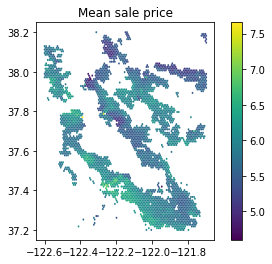

In [23]:
extent = (-121.7, -122.6, 37.2, 38.2)  # left right bottom top

data = recent_sales
values = data.redfin_sale_price

fig, ax = plt.subplots()
ax.set_aspect(1.1)  # ratio of x to y
plt.title('Mean sale price')
hb = plt.hexbin(data.x, data.y, C=values, reduce_C_function=np.mean, 
                extent=extent, mincnt=2, gridsize=100, linewidths=0, bins='log')
fig.colorbar(hb)